In [1]:
!pip install tokenizers
import tensorflow as tf
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, Regex
import tokenizers
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.0 MB/s eta 0:00:0000:0100:01


2023-04-11 13:56:10.139605: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'cnn_lstm'

# Load data

In [3]:
df = pd.read_csv('/home/user/files_for_research_Vova/processed_data.csv', usecols=['review_translate',
                                                            'dataset_name',
                                                            'rating',
                                                           'translated'])

In [4]:
df.head()

,review_translate,rating,dataset_name,translated
0,"Якісна пластмаса , переворот 360 градусвв",5.0,rozetka,False
1,За такі гроші це самий топ,5.0,rozetka,False
2,За такі гроші - просто супер ! Рекомендую .,5.0,rozetka,False
3,Виконує свою роботу не погано . але що ви хоті...,4.0,rozetka,False
4,Купляв на стару сістему як основний під віндов...,4.0,rozetka,False


In [5]:
subsets = pd.read_csv('/home/user/files_for_research_Vova/train_val_test_indices.csv')

In [6]:
subsets.head()

,index,split
0,0,train
1,1,test
2,2,train
3,3,train
4,4,train


In [7]:
subsets = subsets.merge(df[['dataset_name', 'translated']], left_on='index', right_index=True)

# Load tokenizer

In [8]:
tokenizer = Tokenizer.from_file("/home/user/files_for_research_Vova/tokenizer_30k.json")


# Encode text

In [9]:
import seaborn as sns
import numpy as np

In [10]:
sns.set()

In [11]:
df['review_translate'] = df['review_translate'].str.lower()

In [12]:
df['encoded'] = tokenizer.encode_batch(df['review_translate'].values)

In [13]:
df['encoded'] = df['encoded'].apply(lambda x: x.ids)

/tmp/ipykernel_1/3749403729.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(df['encoded'].apply(len)))


<AxesSubplot: xlabel='encoded', ylabel='Density'>

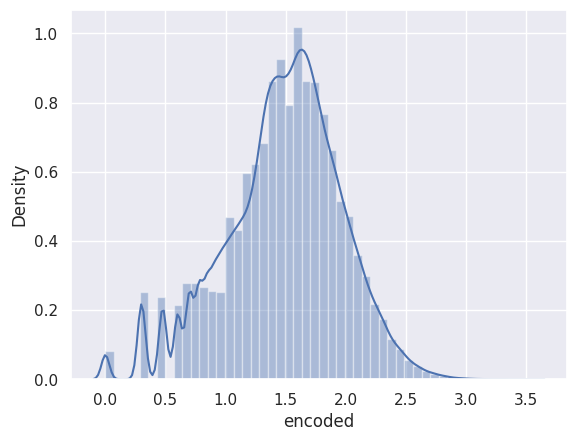

In [14]:
sns.distplot(np.log10(df['encoded'].apply(len)))

In [15]:
np.percentile(df['encoded'].apply(len), 99)

323.0

In [16]:
encoded_tokens = df['encoded'].values

In [17]:
from itertools import chain

In [18]:
padded_tokens = tf.keras.preprocessing.sequence\
.pad_sequences(encoded_tokens, maxlen=300, padding="post")


In [19]:
padded_tokens.shape

(662907, 300)

# Get labels and split data

In [20]:
mapping = dict([(i,c) for c,i in enumerate(df['rating'].unique())])

In [21]:
y = df['rating'].map(mapping).values

In [22]:
num_classes = len(set(y))

In [23]:
train_indices, val_indices, test_indices = subsets[subsets['split']=='train'].index.tolist(),\
subsets[subsets['split']=='val'].index.tolist(),\
subsets[subsets['split']=='test'].index.tolist()


In [24]:
train_y, val_y, test_y = y[train_indices], y[val_indices], y[test_indices]

In [25]:
train_x, val_x, test_x = padded_tokens[train_indices], padded_tokens[val_indices],\
padded_tokens[test_indices]

In [26]:
train_x.shape

(530324, 300)

# Create  model

In [27]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
input_layer = tf.keras.layers.Input(shape=(300,), name='input')
word_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.get_vocab_size(),
                                                   output_dim=300,
                                                   trainable=True,
                                           name='embedding',
                                           mask_zero=True
                                                   )
conv1d = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu',
                                   name=f'conv_ngram_3')
max_pooling = tf.keras.layers.MaxPool1D(pool_size=2, strides=1,
                                           padding='valid')
dropout = tf.keras.layers.SpatialDropout1D(0.3)
lstm = tf.keras.layers.LSTM(128, name='lstm',
                           return_sequences=False)

embedded = dropout(word_embedding(input_layer))
convolved = conv1d(embedded)
max_pooled = max_pooling(convolved)
hidden_state = lstm(max_pooled)
x = tf.keras.layers.Dense(128, activation='relu', name='dense')(hidden_state)
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(x)
model = tf.keras.Model(input_layer, output)

2023-04-11 13:57:45.834725: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 13:57:46.030253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14148 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:03:00.0, compute capability: 8.6


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          9000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 300)         0         
 ropout1D)                                                       
                                                                 
 conv_ngram_3 (Conv1D)       (None, 298, 100)          90100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 297, 100)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               117248

# Compile model

In [29]:
model.compile(loss='sparse_categorical_crossentropy', \
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

# Early stopping

In [30]:
import operator
class EarlyStopping:
    def __init__(self, tolerance=5, mode='min'):
        assert mode in ['min','max'], 'Mode should be min or max'
        self.mode = operator.lt if mode=='min' else operator.gt 
        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False
        self.extremum_value = None
        self.best_model = None
    
    @staticmethod
    def copy_model(model):
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())
        return copied_model
        
    def __call__(self, val, model):
        if self.extremum_value is None:
            self.extremum_value = val
            self.best_model = self.copy_model(model)
        else:
            if not self.mode(val, self.extremum_value):
                self.counter+=1
            else:
                self.extremum_value = val
                self.best_model = self.copy_model(model)
                self.counter = 0
        
        if self.counter==self.tolerance:
            self.early_stop=True

# Train model

In [31]:
from sklearn.metrics import f1_score

In [32]:
def evaluate_on_datasets(y_true, y_pred, split='val'):
    d = {}
    for dataset_name in subsets['dataset_name'].unique():
            idx = subsets[subsets['split']==split].copy()
            idx['index'] = list(range(idx.shape[0]))
            idx = idx[(idx['dataset_name']==dataset_name)]\
            ['index'].values.tolist()
            score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='micro')
            print(f'{split} f1 score for dataset {dataset_name} : {score}')
            d[f'{split}_f1_{dataset_name}'] = score
            
    for flag in [True, False]:
        idx = subsets[subsets['split']==split].copy()
        idx['index'] = list(range(idx.shape[0]))
        idx = idx[idx['translated']==flag]['index'].values.tolist()
        score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='micro')
        print(f'{split} f1 score for translated=={flag} : {score}')
        d[f'{split}_f1_translated=={flag}'] = score
    return d

In [33]:
def update_history(history, d):
    for key, value in d.items():
        res = history.get(key, [])
        res.append(value)
        history[key] = res

In [34]:
early_stopping = EarlyStopping(mode='max', tolerance=4)

In [35]:
def training_loop(model, epochs=10, batch_size=128):
    dict_history = {}
    for i in range(epochs):
        
        #train model
        history = model.fit(train_x, train_y, validation_data=(val_x, val_y), 
          epochs=1, batch_size=batch_size,
                           verbose=0)
        train_loss, val_loss = history.history['loss'][-1], history.history['val_loss'][-1]
        
        #evaluate model
        train_prediction = np.argmax(model.predict(train_x, batch_size), axis=-1)
        val_prediction = np.argmax(model.predict(val_x, batch_size), axis=-1)
        train_f1 = f1_score(y_true=train_y, y_pred=train_prediction,
                           average='micro')
        val_f1 = f1_score(y_true=val_y, y_pred=val_prediction,
                         average='micro')
        
        #printing evaluation
        print(f'Epoch {i}')
        print(f'Overall train f1 : {train_f1}, overall val f1: {val_f1}')
        print(f'Train loss : {train_loss}, val loss: {val_loss}')
        d_train = evaluate_on_datasets(y_true=train_y, y_pred=train_prediction, split='train')
        d_val = evaluate_on_datasets(y_true=val_y, y_pred=val_prediction, split='val')
            
        if i!=epochs-1:
            print('-'*30)
            
        #save history
        update_history(dict_history, d_train)
        update_history(dict_history, d_val)
        update_history(dict_history, {'train_f1': train_f1})
        update_history(dict_history, {'val_f1': val_f1})
        update_history(dict_history, {'train_loss': train_loss})
        update_history(dict_history, {'val_loss': val_loss})
        #early stopping
        
        early_stopping(val_f1, model)
        if early_stopping.early_stop:
            print('Stopping early')
            model = early_stopping.best_model
            break
        
    return dict_history, model

In [36]:
dict_history, model = \
training_loop(model, epochs=20, batch_size=1024)

2023-04-11 13:58:07.103810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-11 13:58:07.650907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-11 13:58:07.716873: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f72ec9418b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-11 13:58:07.716962: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-04-11 13:58:07.724323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-11 13:58:07.894833: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

65/65 [==============================] - 2s 24ms/step
Epoch 0
Overall train f1 : 0.6556143037086762, overall val f1: 0.6554382259767687
Train loss : 1.0960532426834106, val loss: 1.076014518737793
train f1 score for dataset rozetka : 0.7133590915907053
train f1 score for dataset tripadvisor_hotels_ukraine : 0.5578231292517006
train f1 score for dataset tripadvisor_restaurants_ukraine : 0.5781683142423767
train f1 score for translated==True : 0.6391641979991576
train f1 score for translated==False : 0.7258784354654341
val f1 score for dataset rozetka : 0.7142273725049773
val f1 score for dataset tripadvisor_hotels_ukraine : 0.5567371450018767
val f1 score for dataset tripadvisor_restaurants_ukraine : 0.5762330665829802
val f1 score for translated==True : 0.6383168869856638
val f1 score for translated==False : 0.7285373608903021
------------------------------
65/65 [==============================] - 2s 24ms/step
Epoch 1
Overall train f1 : 0.6552352901245276, overall val f1: 0.65509126565

In [37]:
dict_history

{'train_f1_rozetka': [0.7133590915907053,
  0.7134420455161808,
  0.7133814253398718,
  0.7630070159877739,
  0.7972606061379524,
  0.8191030128227625,
  0.8324139273259802,
  0.8489313301023843,
  0.8548019155975713],
 'train_f1_tripadvisor_hotels_ukraine': [0.5578231292517006,
  0.5570099304089452,
  0.5557744937055282,
  0.6322308233638283,
  0.7346938775510203,
  0.7709281413714911,
  0.7918836500117287,
  0.8110876534521855,
  0.8217374306044257],
 'train_f1_tripadvisor_restaurants_ukraine': [0.5781683142423767,
  0.577024164443747,
  0.5770699304356922,
  0.675113761179978,
  0.7550734871070662,
  0.7861682096343952,
  0.805494534232962,
  0.8219310633401329,
  0.8351312830168942],
 'train_f1_translated==True': [0.6391641979991576,
  0.6386778336540856,
  0.638482357075205,
  0.7099406821667182,
  0.7709363560838596,
  0.7978004230671671,
  0.8145695210125686,
  0.8319064318775758,
  0.8407145134378512],
 'train_f1_translated==False': [0.7258784354654341,
  0.7259579543760251,
  

# Show charts

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
def plot_history(dict_history, columns):
    plt.figure(figsize=(12,8))
    for i in columns:
        to_plot = dict_history[i]
        plt.plot(range(len(to_plot)), to_plot, 'o-')
    plt.xticks(range(len(to_plot)), range(len(to_plot)))
    plt.xlabel('Epochs')
    plt.legend(columns)

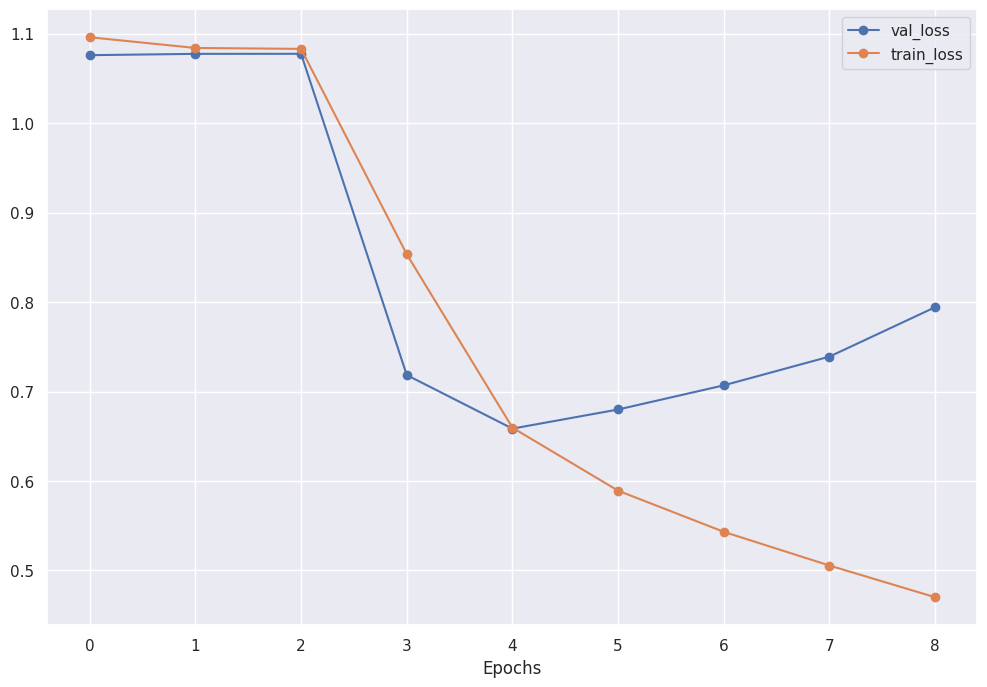

In [40]:
plot_history(dict_history, ['val_loss', 'train_loss'])

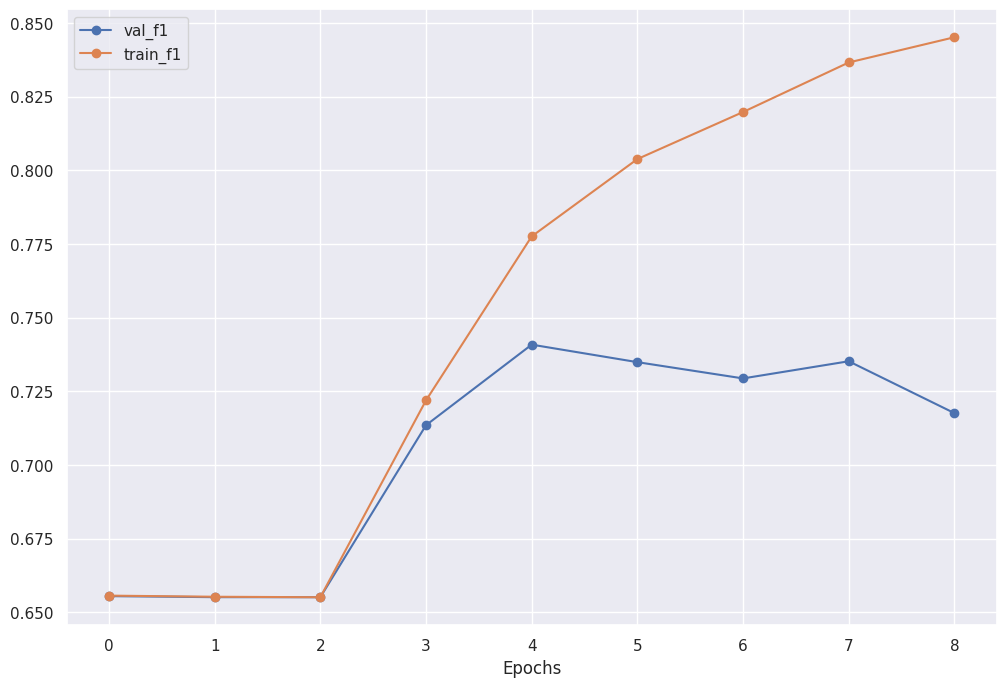

In [41]:
plot_history(dict_history, ['val_f1', 'train_f1'])

# Evaluate model

In [45]:
test_predictions = np.argmax(model.predict(test_x, batch_size=1024), axis=-1)

65/65 [==============================] - 2s 22ms/step


In [46]:
test_f1 = f1_score(y_true=test_y, y_pred=test_predictions,
                         average='micro')
print(f'Overall test f1-score : {test_f1}')

Overall test f1-score : 0.742370989395562


In [47]:
test_results = evaluate_on_datasets(y_true=test_y, y_pred=test_predictions,split='test')
                     

test f1 score for dataset rozetka : 0.7671201408918042
test f1 score for dataset tripadvisor_hotels_ukraine : 0.6906429822366775
test f1 score for dataset tripadvisor_restaurants_ukraine : 0.7132845188284518
test f1 score for translated==True : 0.7336413772544342
test f1 score for translated==False : 0.7794944933048095


# Confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
np.unique(test_y)

array([0, 1, 2, 3, 4])

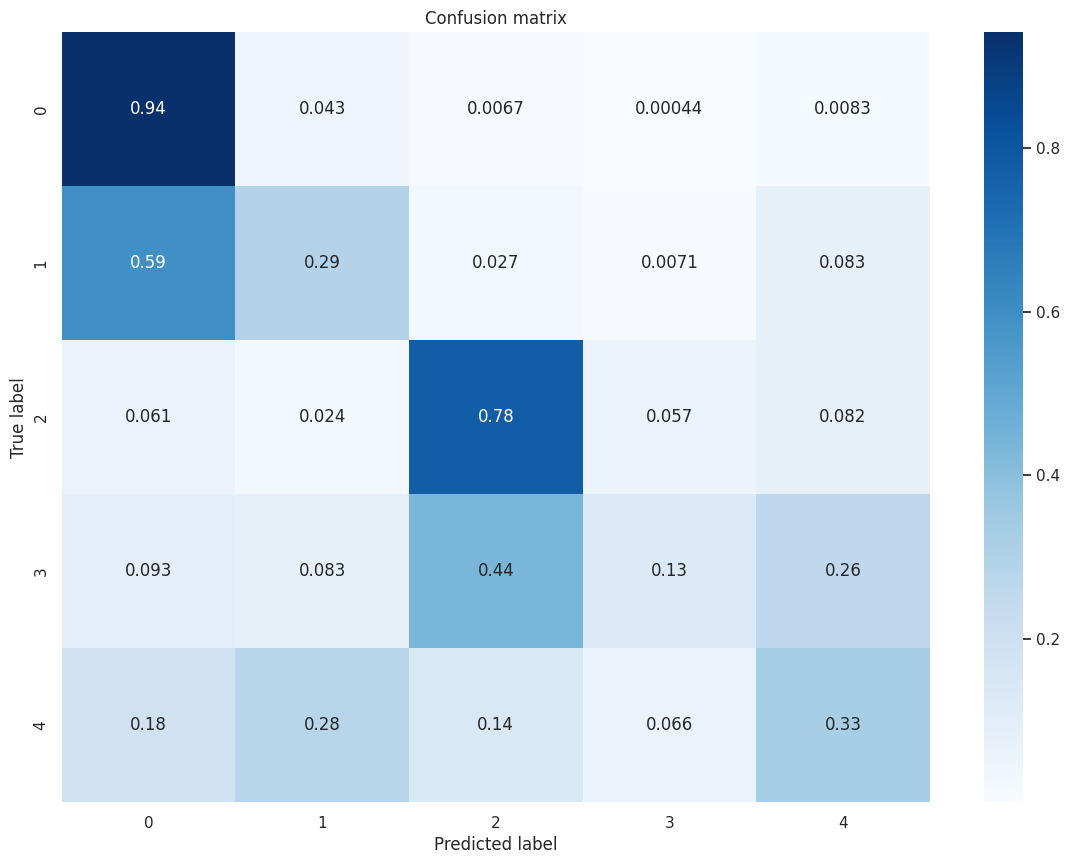

In [50]:
matrix = confusion_matrix(test_y, test_predictions)
matrix_scaled = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,10))
sns.heatmap(matrix_scaled, annot=True, cmap=plt.cm.Blues, xticklabels=np.unique(test_y),\
            yticklabels=np.unique(test_y))
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

# Save history results

In [51]:
history = pd.DataFrame(dict_history)
for k,v in test_results.items():
    history[k] = v

In [52]:
history['model'] = model_name

In [53]:
history.to_csv("/home/user/jupyter_notebooks/Ukranian-SA/notebooks/training/training_results.csv", mode='a', header=None, index=None)